In [1]:
import pandas as pd
from collections import namedtuple
from scipy.stats import ttest_rel
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
MAIN_DATA_PATH = "../../ilmart-data"

In [3]:
CSVRow = namedtuple("CSVRow", ["dataset", "method", "ndcg1", "ndcg5", "ndcg10", "M", "I", "sign_ndcg1", "sign_ndcg5",
                               "sign_ndcg10"])
CUTOFFS = [1, 5, 10]
N_FEATS = {"web30k": 136, "yahoo": 699, "istella": 220}
EBM_FIXED_N_INTER = 50
ILMART_STRATEGIES = ["greedy", "prev", "contrib"]
P_VALUE_THRESHOLD = 0.01
BONFERRONI_CORRETION_COEFF = 14

# Table 3

In [4]:
table3 = []
best_ndcg_per_dataset = {1: {"web30k": 0, "yahoo": 0, "istella": 0},
                         5: {"web30k": 0, "yahoo": 0, "istella": 0},
                         10: {"web30k": 0, "yahoo": 0, "istella": 0}}

NRGAM

In [5]:
df = pd.read_csv(f"{MAIN_DATA_PATH}/nrgam/eval.csv")
baseline_infos = defaultdict(dict)
for dataset_name in df["dataset"].unique():
    df_dataset = df[(df["dataset"] == dataset_name)]
    mean_ndcgs = {}
    for cutoff in CUTOFFS:
        mean_ndcgs[cutoff] = df_dataset[df_dataset["cutoff"] == cutoff]["ndcg"].mean()
        best_ndcg_per_dataset[cutoff][dataset_name] = max(mean_ndcgs[cutoff],
                                                          best_ndcg_per_dataset[cutoff][dataset_name])
        baseline_df = df_dataset[df_dataset["cutoff"] == cutoff][["ndcg", "query_id"]]
        baseline_df = baseline_df.sort_values(by="query_id")
        baseline = baseline_df["ndcg"].to_numpy()
        query_ids = baseline_df["query_id"].to_numpy()
        baseline_infos[dataset_name][cutoff] = baseline, query_ids
    table3.append(CSVRow(dataset_name,
                         r"\nrgam",
                         mean_ndcgs[1],
                         mean_ndcgs[5],
                         mean_ndcgs[10],
                         N_FEATS[dataset_name],
                         0,
                         False,
                         False,
                         False))

EBM

In [6]:

df = pd.read_csv(f"{MAIN_DATA_PATH}/ebm/eval.csv")
for dataset_name in df["dataset"].unique():
    for inter_attr in ["no-inter", "inter"]:
        df_dataset = df[(df["dataset"] == dataset_name) & (df["inter"] == inter_attr)]
        mean_ndcgs = {}
        sign_ndcgs = {}
        for cutoff in CUTOFFS:
            mean_ndcgs[cutoff] = df_dataset[df_dataset["cutoff"] == cutoff]["ndcg"].mean()
            best_ndcg_per_dataset[cutoff][dataset_name] = max(mean_ndcgs[cutoff],
                                                              best_ndcg_per_dataset[cutoff][dataset_name])

            baseline_ndcgs, baseline_ids = baseline_infos[dataset_name][cutoff]
            mean_baseline = baseline_ndcgs.mean()

            experimental_ndcgs_df = df_dataset[df_dataset["cutoff"] == cutoff][["ndcg", "query_id"]]
            experimental_ndcgs_df = experimental_ndcgs_df.sort_values(by="query_id")
            experimental_ndcgs = experimental_ndcgs_df["ndcg"].to_numpy()
            experiment_qids = experimental_ndcgs_df["query_id"].to_numpy()
            if not (baseline_ids == experiment_qids).all():
                raise ValueError("Query ids are not the same")
            statistic, p_value = ttest_rel(baseline_ndcgs, experimental_ndcgs)

            sign_ndcgs[cutoff] = False
            if mean_ndcgs[cutoff] > mean_baseline and p_value < P_VALUE_THRESHOLD / BONFERRONI_CORRETION_COEFF:
                sign_ndcgs[cutoff] = True

        name = r"\ebm$_i$" if inter_attr == "inter" else r"\ebm"
        table3.append(CSVRow(dataset_name,
                             name,
                             mean_ndcgs[1],
                             mean_ndcgs[5],
                             mean_ndcgs[10],
                             N_FEATS[dataset_name],
                             EBM_FIXED_N_INTER if inter_attr == "inter" else 0,
                             sign_ndcgs[1],
                             sign_ndcgs[5],
                             sign_ndcgs[10]
                             ))

Ilmart

In [7]:
df = pd.read_csv(f"{MAIN_DATA_PATH}/ft/eval.csv")
STRATEGY_MAPPING = {"greedy": {"no": r"\ilmartgreedy",
                               "greedy": r"\ilmartgreedygreedy",
                               "prev": r"\ilmartgreedyprev",
                               "contrib": r"\ilmartgreedycontrib"},
                    "prev": {"no": r"\ilmartprev",
                             "greedy": r"\ilmartprevgreedy",
                             "prev": r"\ilmartprevprev",
                             "contrib": r"\ilmartprevcontrib"},
                    "contrib": {"no": r"\ilmartcontrib",
                                "greedy": r"\ilmartcontribgreedy",
                                "prev": r"\ilmartcontribprev",
                                "contrib": r"\ilmartcontribcontrib"}}

for dataset_name in df["dataset"].unique():
    df_dataset = df[(df["dataset"] == dataset_name)]
    for main_strategy in ILMART_STRATEGIES:
        for inter_strategy in ILMART_STRATEGIES + ["no"]:
            main_strategy_df = df_dataset[df_dataset["main_strategy"] == main_strategy]
            if inter_strategy != "no":
                df_strategy = main_strategy_df[main_strategy_df["inter_strategy"] == inter_strategy]
            else:
                df_strategy = main_strategy_df[main_strategy_df["inter_strategy"].isna()]

            strategy_name = STRATEGY_MAPPING[main_strategy][inter_strategy]
            n_main_effects = df_strategy["n_main_effects"].iloc[0]
            n_inter_effects = df_strategy["n_inter_effects"].iloc[0]

            mean_ndcgs = {}
            sign_ndcgs = {}

            for cutoff in CUTOFFS:
                mean_ndcgs[cutoff] = df_strategy[df_strategy["cutoff"] == cutoff]["ndcg"].mean()
                best_ndcg_per_dataset[cutoff][dataset_name] = max(mean_ndcgs[cutoff],
                                                                  best_ndcg_per_dataset[cutoff][dataset_name])

                baseline_ndcgs, baseline_ids = baseline_infos[dataset_name][cutoff]
                mean_baseline = baseline_ndcgs.mean()

                experimental_ndcgs_df = df_strategy[df_strategy["cutoff"] == cutoff][["ndcg", "query_id"]]
                experimental_ndcgs_df = experimental_ndcgs_df.sort_values(by="query_id")
                experimental_ndcgs = experimental_ndcgs_df["ndcg"].to_numpy()
                experiment_qids = experimental_ndcgs_df["query_id"].to_numpy()

                if not (baseline_ids == experiment_qids).all():
                    raise ValueError("Query ids are not the same")
                statistic, p_value = ttest_rel(baseline_ndcgs, experimental_ndcgs)

                sign_ndcgs[cutoff] = False

                if mean_ndcgs[cutoff] > mean_baseline and p_value < P_VALUE_THRESHOLD / BONFERRONI_CORRETION_COEFF:
                    sign_ndcgs[cutoff] = True

            table3.append(CSVRow(dataset_name,
                                 strategy_name,
                                 mean_ndcgs[1],
                                 mean_ndcgs[5],
                                 mean_ndcgs[10],
                                 n_main_effects,
                                 n_inter_effects,
                                 sign_ndcgs[1],
                                 sign_ndcgs[5],
                                 sign_ndcgs[10]))


In [8]:
for dataset_name in ["web30k", "yahoo", "istella"]:
    to_print = pd.DataFrame(table3)
    to_print = to_print[to_print["dataset"] == dataset_name]
    baseline_ndcg = to_print[to_print["method"] == r"\nrgam"]["ndcg10"].values
    to_print["delta"] = (to_print["ndcg10"].values - baseline_ndcg) / baseline_ndcg
    to_print["delta"] = to_print["delta"].apply(lambda x: f"+{x * 100:.2f}" if x > 0 else f"{x * 100:.2f}")
    to_print = to_print.drop(columns="dataset")
    to_print["method"] = pd.Categorical(to_print['method'],
                                        [r"\nrgam",
                                         r"\ebm",
                                         r"\ilmartgreedy",
                                         r"\ilmartprev",
                                         r"\ilmartcontrib",
                                         r"\ebm$_i$",
                                         r"\ilmartgreedygreedy",
                                         r"\ilmartgreedyprev",
                                         r"\ilmartgreedycontrib",
                                         r"\ilmartprevgreedy",
                                         r"\ilmartprevprev",
                                         r"\ilmartprevcontrib",
                                         r"\ilmartcontribgreedy",
                                         r"\ilmartcontribprev",
                                         r"\ilmartcontribcontrib",
                                         ])
    to_print = to_print.sort_values(by=["method"])
    for idx, row in to_print.iterrows():
        for cutoff in CUTOFFS:
            the_best = best_ndcg_per_dataset[cutoff][dataset_name] == row[f"ndcg{cutoff}"]
            if row[f"sign_ndcg{cutoff}"] and the_best:
                to_print.loc[idx, f"ndcg{cutoff}"] = f"$\\mathbf{{{row[f'ndcg{cutoff}']:.4f}}}^*$"
            elif row[f"sign_ndcg{cutoff}"]:
                to_print.loc[idx, f"ndcg{cutoff}"] = f"${row[f'ndcg{cutoff}']:.4f}^*$"
            else:
                to_print.loc[idx, f"ndcg{cutoff}"] = f"${row[f'ndcg{cutoff}']:.4f}$"

    to_print = to_print.drop(columns=["sign_ndcg1", "sign_ndcg5", "sign_ndcg10"])
    latex_res = to_print.style.hide(axis=0).to_latex()
    latex_list = latex_res.splitlines()
    for idx_mid_rule in [7]:
        latex_list.insert(idx_mid_rule, '\midrule')

    latex_list[
        1] = r"Method &              nDCG@1 &             nDCG@5 &             nDCG@10 &   $|\mathcal{M}|$ & $|\mathcal{I}|$&  \%$\Delta$ \\"
    latex_res = '\n'.join(latex_list)
    print(latex_res)
    print("-" * 10)

\begin{tabular}{llllrrl}
Method &              nDCG@1 &             nDCG@5 &             nDCG@10 &   $|\mathcal{M}|$ & $|\mathcal{I}|$&  \%$\Delta$ \\
\nrgam & $0.4346$ & $0.4310$ & $0.4514$ & 136 & 0 & 0.00 \\
\ebm & $0.4163$ & $0.4302$ & $0.4552$ & 136 & 0 & +0.85 \\
\ilmartgreedy & $0.4553^*$ & $0.4519^*$ & $0.4721^*$ & 50 & 0 & +4.58 \\
\ilmartprev & $0.4470$ & $0.4467^*$ & $0.4669^*$ & 42 & 0 & +3.43 \\
\ilmartcontrib & $0.4557^*$ & $0.4506^*$ & $0.4714^*$ & 50 & 0 & +4.43 \\
\midrule
\ebm$_i$ & $0.4688^*$ & $0.4615^*$ & $0.4814^*$ & 136 & 50 & +6.65 \\
\ilmartgreedygreedy & $0.4918^*$ & $0.4801^*$ & $0.4972^*$ & 50 & 50 & +10.15 \\
\ilmartgreedyprev & $0.4847^*$ & $0.4737^*$ & $0.4924^*$ & 50 & 46 & +9.08 \\
\ilmartgreedycontrib & $0.4900^*$ & $0.4800^*$ & $0.4958^*$ & 50 & 49 & +9.83 \\
\ilmartprevgreedy & $0.4867^*$ & $0.4752^*$ & $0.4920^*$ & 42 & 50 & +8.99 \\
\ilmartprevprev & $0.4791^*$ & $0.4710^*$ & $0.4883^*$ & 42 & 50 & +8.17 \\
\ilmartprevcontrib & $\mathbf{0.4958}^*$ 

# Figure 8

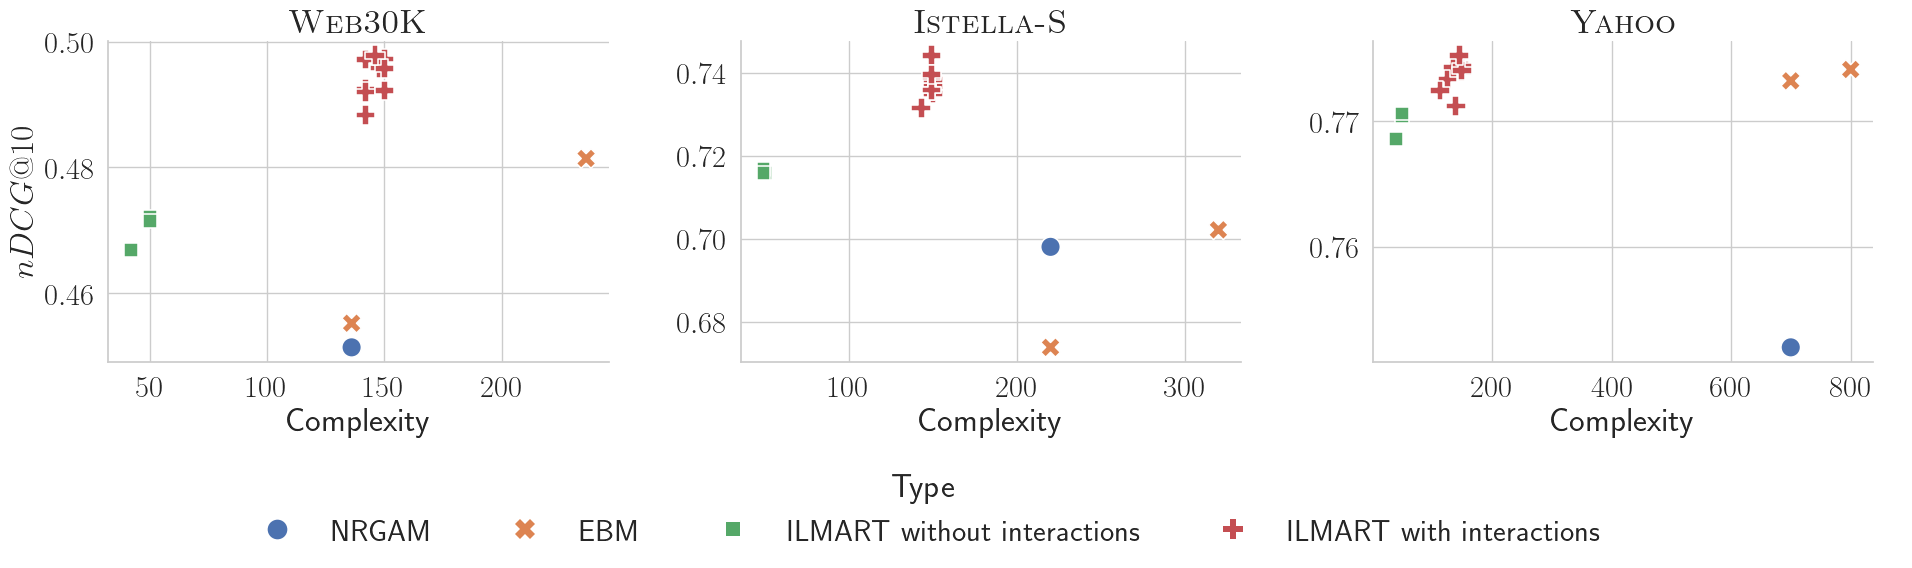

In [9]:
CUTOFF = 10
sns.set_theme(font_scale=2, style="whitegrid", rc={'text.usetex': True})
EBM_N_INTER = 50

ILMART_STRATEGY_PLOT_MAPPING = {"greedy": r"ILMART$-\sigma_{mg}$",
                                "prev": r"ILMART$-\sigma_{mp}$",
                                "contrib": r"ILMART$-\sigma_{mc}$",
                                "greedy-greedy": r"ILMART$-\sigma_{mg}-\sigma_{ig}$",
                                "greedy-prev": r"ILMART$-\sigma_{mg}-\sigma_{ip}$",
                                "greedy-contrib": r"ILMART$-\sigma_{mg}-\sigma_{ip}$",
                                "prev-greedy": r"ILMART$-\sigma_{mp}-\sigma_{ig}$",
                                "prev-prev": r"ILMART$-\sigma_{mp}-\sigma_{ip}$",
                                "prev-contrib": r"ILMART$-\sigma_{mp}-\sigma_{ip}$",
                                "contrib-greedy": r"ILMART$-\sigma_{mc}-\sigma_{ig}$",
                                "contrib-prev": r"ILMART$-\sigma_{mc}-\sigma_{ip}$",
                                "contrib-contrib": r"ILMART$-\sigma_{mc}-\sigma_{ip}$", }

DATASET_MAPPING_PLOT = {"web30k": r"\textsc{Web30K}",
                        "yahoo": r"\textsc{Yahoo}",
                        "istella": r"\textsc{Istella-S}"}

TradeoffPlot = namedtuple("TradeoffPlot", ["Dataset", "Method", "ndcg", "Complexity", "Type"])
nrgam_df = pd.read_csv(f"{MAIN_DATA_PATH}/nrgam/eval.csv")
ebm_df = pd.read_csv(f"{MAIN_DATA_PATH}/ebm/eval.csv")
ilmart_df = pd.read_csv(f"{MAIN_DATA_PATH}/ft/eval.csv")

tradeoff_plots_entry = []
for dataset_name in nrgam_df["dataset"].unique():
    nrgam_ndcg = nrgam_df[(nrgam_df["dataset"] == dataset_name) & (nrgam_df["cutoff"] == CUTOFF)]["ndcg"].mean()
    tradeoff_plots_entry.append(
        TradeoffPlot(DATASET_MAPPING_PLOT[dataset_name], "NRGAM", nrgam_ndcg, N_FEATS[dataset_name], "NRGAM"))

    # EBM no inter
    ebm_filter = (ebm_df["dataset"] == dataset_name) & (ebm_df["cutoff"] == CUTOFF)
    ebm_fileter_no_inter = ebm_filter & (ebm_df["inter"] == "no-inter")
    ebm_ndcg = ebm_df[ebm_fileter_no_inter]["ndcg"].mean()
    tradeoff_plots_entry.append(
        TradeoffPlot(DATASET_MAPPING_PLOT[dataset_name], r"EBM", ebm_ndcg, N_FEATS[dataset_name], "EBM"))

    # EBM inter
    ebf_filter_inter = ebm_filter & (ebm_df["inter"] == "inter")
    ebm_ndcg = ebm_df[ebf_filter_inter]["ndcg"].mean()
    tradeoff_plots_entry.append(TradeoffPlot(DATASET_MAPPING_PLOT[dataset_name],
                                             r"EBM$_i$",
                                             ebm_ndcg,
                                             N_FEATS[dataset_name] + EBM_N_INTER * 2,
                                             "EBM"))

    for strategy_main in ILMART_STRATEGIES:
        ilmart_filter = ((ilmart_df["dataset"] == dataset_name) &
                         (ilmart_df["cutoff"] == CUTOFF) &
                         (ilmart_df["main_strategy"] == strategy_main))
        ilmart_filter_main = ilmart_filter & (ilmart_df["n_inter_effects"] == 0)
        ilmart_ndcg = ilmart_df[ilmart_filter_main]["ndcg"].mean()
        ilmart_n_feat_used = ilmart_df[ilmart_filter_main]["n_main_effects"].iloc[0]
        tradeoff_plots_entry.append(TradeoffPlot(DATASET_MAPPING_PLOT[dataset_name],
                                                 f"{ILMART_STRATEGY_PLOT_MAPPING[strategy_main]}",
                                                 ilmart_ndcg,
                                                 ilmart_n_feat_used, "ILMART without interactions"))

        for strategy_inter in ILMART_STRATEGIES:
            ilmart_filter_inter = ilmart_filter & (ilmart_df["inter_strategy"] == strategy_inter)
            ilmart_ndcg = ilmart_df[ilmart_filter_inter]["ndcg"].mean()
            ilmart_n_main_effects = ilmart_df[ilmart_filter_inter]["n_main_effects"].iloc[0]
            ilmart_n_inter_effects = ilmart_df[ilmart_filter_inter]["n_inter_effects"].iloc[0]
            tradeoff_plots_entry.append(TradeoffPlot(DATASET_MAPPING_PLOT[dataset_name],
                                                     f"{ILMART_STRATEGY_PLOT_MAPPING[f'{strategy_main}-{strategy_inter}']}",
                                                     ilmart_ndcg,
                                                     ilmart_n_feat_used + ilmart_n_inter_effects * 2,
                                                     "ILMART with interactions"))

greens = sns.color_palette("Greens", 12)
oranges = sns.color_palette("Oranges", 2)
standard_palette = sns.color_palette(None, 1)

df_to_plot = pd.DataFrame(tradeoff_plots_entry)
fg = sns.relplot(data=pd.DataFrame(tradeoff_plots_entry),
                 x="Complexity",
                 y="ndcg",
                 col="Dataset",
                 hue="Type",
                 style="Type",
                 s=200,
                 facet_kws={'sharey': False, "sharex": False})
fg.set_titles(col_template="{col_name}")
fg.set_ylabels(r"$nDCG@10$")
fg.set_xlabels(r"Complexity")
sns.move_legend(fg, "lower center", bbox_to_anchor=(0.5, -0.2), ncol=4)
fg.add_legend()
plt.savefig("plots/comparison.pdf", bbox_inches="tight")
